In [2]:
import os
import numpy as np
import cv2
import random
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

# Load MNIST digits
(x_train, y_train), (_, _) = mnist.load_data()

# Group digits by label
digit_map = {i: [] for i in range(10)}
for img, label in zip(x_train, y_train):
    digit_map[label].append(img)

# Create output folder
output_dir = "synthetic_phone_numbers"
os.makedirs(output_dir, exist_ok=True)

# Function to create one phone number image
def create_phone_number_image(digits_per_image=10):
    digits = [random.randint(0, 9) for _ in range(digits_per_image)]
    images = [random.choice(digit_map[d]) for d in digits]
    full_image = np.hstack(images)  # combine digits side by side
    return full_image, ''.join(str(d) for d in digits)

# Generate dataset
def generate_dataset(num_images=1000):
    for i in tqdm(range(num_images)):
        img, label = create_phone_number_image()
        cv2.imwrite(f"{output_dir}/{i}_{label}.png", img)

generate_dataset(1000)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 1000/1000 [00:00<00:00, 3800.08it/s]


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import os

# Load and prepare your synthetic data (make sure to call this only after generating the dataset)
def load_data(image_dir="synthetic_phone_numbers"):
    X, y = [], []
    for fname in os.listdir(image_dir):
        if fname.endswith(".png"):
            label = fname.split("_")[1].split(".")[0]
            img = cv2.imread(os.path.join(image_dir, fname), cv2.IMREAD_GRAYSCALE)
            for i, digit in enumerate(label):
                crop = img[:, i*28:(i+1)*28]  # segment 28x28 digit
                if crop.shape == (28, 28):
                    X.append(crop)
                    y.append(int(digit))
    X = np.array(X).reshape(-1, 28, 28, 1) / 255.0
    y = to_categorical(np.array(y), num_classes=10)
    return X, y

X, y = load_data()

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Output layer for 10 digits (0-9)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (assuming you have the dataset loaded)
model.fit(X, y, epochs=5, batch_size=128, validation_split=0.1)

# Save the model after training
model.save("digit_classifier.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.5784 - loss: 1.3463 - val_accuracy: 0.9260 - val_loss: 0.2589
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9252 - loss: 0.2437 - val_accuracy: 0.9520 - val_loss: 0.1524
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9649 - loss: 0.1212 - val_accuracy: 0.9610 - val_loss: 0.1270
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9748 - loss: 0.0846 - val_accuracy: 0.9700 - val_loss: 0.1069
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9810 - loss: 0.0589 - val_accuracy: 0.9710 - val_loss: 0.0918


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📞 Predicted phone number: 6685260654


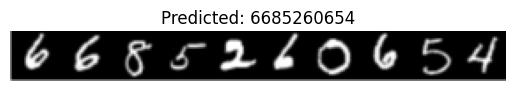

In [4]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model("digit_classifier.h5")

# Function to predict digits from a phone number image
def predict_phone_number(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    phone_number = ""
    for i in range(10):  # 10 digits
        digit_img = img[:, i*28:(i+1)*28]
        digit_img = digit_img.reshape(1, 28, 28, 1) / 255.0
        pred = model.predict(digit_img)
        phone_number += str(np.argmax(pred))
    return phone_number

# Example usage
image_path = "/content/pn.png"  # Provide your test image here
result = predict_phone_number(image_path)
print("📞 Predicted phone number:", result)

# Optional: Display the image
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title(f"Predicted: {result}")
plt.axis("off")
plt.show()